# Fully Autonomous Line-Follower Drone
This project was realized for the [REDS institute](https://reds.heig-vd.ch/) @ [HEIG-VD](https://heig-vd.ch/).

Authors: Guillaume Chacun, Mehdi Akeddar, Thomas Rieder, Bruno Da Rocha Carvalho and Marina Zapater<br>
REDS. School of Engineering and Management Vaud, HES-SO University of Applied sciences and Arts Western Switzerland<br>
Email: {guillaume.chacun, mehdi.akeddar, thomas.rieder, bruno.darochacarvalho, marina.zapater}@heig-vd.ch<br>

## Goal
This Jupyter notebook is used to train a DDPG (reinforcement learning) model to control a drone, specifically to guide it to follow a predefined line on the ground. A separate deep learning model is used to identify and track the line from images captured by the on-board camera. The pilot module processes real-world normalised coordinates of points A and B (see image below) and generates forward, lateral and angular velocities for the drone.

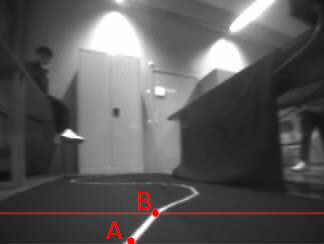

## Content of this repository
- This Notebook is used to train the reinforcement learning model.
- *ddpg_torch.py* : DDPG related classes (OUActionNoise, ReplayBuffer, CriticNetwork, ActorNetwork, Agent).
- *Drone.py* : Class to simulate the behavior of the drone.
- *Line.py* : Class to generate a random line for the drone to follow.
- *Environment.py* : Class to handle the simulation (episodes). Contains an instance of Drone and Line.

## Setup
Install dependencies:

```bash
poetry install
```

Activate the virtual environment of Poetry:
```bash
poetry shell
```

Start your Jupyter Lab server:
```bash
jupyter lab
```

## Disclaimer
Most of the DDPG code is from [@philtabor's GitHub](https://github.com/philtabor/Youtube-Code-Repository/blob/master/ReinforcementLearning/PolicyGradient/DDPG/pytorch/lunar-lander/ddpg_torch.py) (last visited on March 5th, 2024).

# Imports

In [1]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from multiprocessing import Process, Event
import neptune
import numpy as np
from tqdm import tqdm # does not work with tqdm.notebook
import yaml

In [2]:
%matplotlib inline
# does not work with %matplotlib widgets

In [3]:
%load_ext autoreload
%autoreload 2
from ddpg_torch import Agent
from Drone import Drone
from Environment import Environment

# Parameters

In [4]:
log = True

In [5]:
load_weights = False

In [6]:
seed = 23
np.random.seed(seed)

In [7]:
# DPPG parameters
actor_lr  = 1e-5
critic_lr = 1e-4
ddpg_tau = 1e-3
batch_size = 256
layer1_size = 400
layer2_size = 300
memory_size = 0 # size of 0 disables the agent's memory

In [8]:
# Environment parameters
max_allowed_dist = 1. # from the drone to the nearest point on the line (meters)
# Reward
alpha = 1.5 # distance
beta = 0.5  # speed
gamma = 1.   # p1 centered
delta = 1.   # angle
terminated_reward = -2 * sum([alpha, beta, gamma, delta])

In [9]:
# Drone parameters
allow_x_movement = True
z_min_speed = .05        # meters / second
z_max_speed = .30        # meters / second
x_max_speed = .15        # meters / second
max_angular_speed = 45.  # degrees / seconds
max_drift = 0.           # meters

In [10]:
state_dims = 3
n_actions = 3 if allow_x_movement else 2

# Setup

## Neptune

In [11]:
# load neptune api key
with open('.neptune_config.yaml', 'r') as config_file:
    neptune_config = yaml.safe_load(config_file)
api_token = neptune_config.get('api_token')

In [12]:
if log:
    # init neptune
    run = neptune.init_run(
        project='chacungu/Drone-Controller-with-Reinforcement-Learning', 
        api_token=api_token, 
        tags=['reds'],
        capture_stdout=False,
        capture_stderr=False,
        capture_traceback=False,
        capture_hardware_metrics=False,
    )
    run['parameters'] = {
        'Model/load_weights': load_weights,
        'Model/state_dims': state_dims,
        'Model/n_actions': n_actions,
        
        'Model/actor_lr': actor_lr,
        'Model/critic_lr': critic_lr,
        'Model/tau': ddpg_tau,
        'Model/batch_size': batch_size,
        'Model/layer1_size': layer1_size,
        'Model/layer2_size': layer2_size,
        'Model/memory_size': memory_size,
        
        'Environment/max_allowed_dist': max_allowed_dist,
        'Environment/max_drift': max_drift,
        
        'Reward/alpha': alpha,
        'Reward/beta': beta,
        'Reward/gamma': gamma,
        'Reward/delta': delta,
        'Reward/terminated_reward': terminated_reward,

        'Pilot/allow_x_movement': allow_x_movement,
        'Pilot/z_min_speed': z_min_speed,
        'Pilot/z_max_speed': z_max_speed,
        'Pilot/x_max_speed': x_max_speed,
        'Pilot/max_angular_speed': max_angular_speed,
        
        'Drone/height': Drone._height,
        'Drone/fps': Drone._fps,
        'Drone/flight_commands_rate': Drone._flight_commands_rate,
    }

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/chacungu/Drone-Controller-with-Reinforcement-Learning/e/RLCONTROL-77


## GUI

In [13]:
# GUI Toggle Button
def toggle_render_event(change):
    if change.new:
        is_toggle_render.set()
    else:
        is_toggle_render.clear()
    clear_output(wait=True)

is_toggle_render = Event() # shared value storing the state of the Toggle Button
toggle_render = widgets.ToggleButton(value=False, description='Toggle Render')
toggle_render.observe(toggle_render_event, 'value')

In [14]:
# GUI Output area
out = widgets.Output(layout={'border': '1px solid black'})

## Training loop function

In [15]:
environment_params = {
    'run': run,
    'seed': seed,
    'max_allowed_dist': max_allowed_dist,
    'z_min_speed': z_min_speed,
    'z_max_speed': z_max_speed,
    'x_max_speed': x_max_speed,
    'max_angular_speed': max_angular_speed,
    'max_drift': max_drift,
    'allow_x_movement': allow_x_movement,
    'alpha': alpha,
    'beta':beta ,
    'gamma': gamma,
    'delta': delta,
    'terminated_reward': terminated_reward,
}
agent_params = {
    'input_dims': [state_dims + state_dims*memory_size], 
    'n_actions': n_actions, 
    'actor_lr': actor_lr, 
    'critic_lr': critic_lr, 
    'tau': ddpg_tau,
    'batch_size': batch_size, 
    'layer1_size': layer1_size, 
    'layer2_size': layer2_size, 
    'memory_size': memory_size, 
    'allow_x_movement': allow_x_movement,
}

In [16]:
# Training Loop
def run_loop(toggle_render, out, pbar, n_episodes, load_weights):
    # init 
    env = Environment(**environment_params)
    agent = Agent(**agent_params)
    if load_weights:
        agent.load_models()
    score_history = []
    speed_z_history = []
    speed_x_history = []
    speed_a_history = []
    
    for i in range(n_episodes):
        agent.reset_states_memory()
        state = env.reset()
        terminated, truncated, done = False, False, False
        score = 0
        
        episode_history = {
            'speed_z': [],
            'speed_x': [],
            'speed_a': [],
        }
        
        while not done: # while episode is not over
            action = agent.choose_action(state)
            new_state, reward, terminated, truncated = env.step(action)
            done = terminated or truncated
            agent.remember(state, action, reward, new_state, int(done))
            agent.learn()
            score += reward
            state = new_state
            if log:
                run['train/running_score'].log(score)

            # save speeds
            if not allow_x_movement:
                action = [action[0], 0., action[1]]
            speed_z, speed_x, speed_a = env.drone.pilot_speeds_to_drones(*action)
            episode_history['speed_z'].append(speed_z)
            episode_history['speed_x'].append(speed_x)
            episode_history['speed_a'].append(speed_a)
            
            if is_toggle_render.is_set():
                env.render(out)

        # save score & speeds
        score_history.append(score)
        avg_speed_z = np.mean(episode_history['speed_z'])
        speed_z_history.append(avg_speed_z)
        avg_speed_x = np.mean(episode_history['speed_x'])
        speed_x_history.append(avg_speed_x)
        avg_speed_a = np.mean(episode_history['speed_a'])
        speed_a_history.append(avg_speed_a)
        if log:
            run['train/score'].log(score)
            run['train/avg_speed_z'].log(avg_speed_z)
            run['train/avg_speed_x'].log(avg_speed_x)
            run['train/avg_speed_a'].log(avg_speed_a)
            run['train/terminated'].log(terminated)
            run['train/truncated'].log(truncated)

        # update progress bar
        pbar.update(1)
        pbar.set_description(
            'avg score %.3f | avg z %.2f | avg x %.2f | avg a %.1f' % (
                np.mean(score_history[-100:]),
                np.mean(speed_z_history[-100:]),
                np.mean(speed_x_history[-100:]),
                np.mean(speed_a_history[-100:]),
        ))

        # save models
        if i % 100 == 0 and i > batch_size:
            agent.save_models()

# Training

In [17]:
# Display the toggle button and the plot area
display(toggle_render, out)

# Display the progress bar
n_episodes = int(1e9)
pbar = tqdm(total=n_episodes, position=0)

# Start the process that handles the training
process = Process(target=run_loop, args=(toggle_render, out, pbar, n_episodes, load_weights))
process.start()

ToggleButton(value=False, description='Toggle Render')

Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

avg score -6.037 | avg z 0.07 | avg x -0.04 | avg a -5.3:   0%|          | 313/1000000000 [01:41<295609:13:14,  1.06s/it]

In [18]:
# interrupt the training
#process.join()

In [19]:
if log:
    # stop neptune
    run.stop()

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Waiting for the remaining 24 operations to synchronize with Neptune. Do not kill this process.
[neptune] [info   ] All 24 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/chacungu/Drone-Controller-with-Reinforcement-Learning/e/RLCONTROL-73/metadata


# Tests

## Reward func

In [57]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider
import ipywidgets as widgets

slider_a = FloatSlider(value=1., min=0, max=1, step=0.1, description='speed:')
slider_b = FloatSlider(value=0, min=0, max=1, step=0.1, description='dist_p1_C:')
slider_c = FloatSlider(value=0, min=-1, max=1, step=0.1, description='drone_angle:')
slider_d = FloatSlider(value=0, min=-1, max=1, step=0.1, description='line_angle:')

def update_plot(speed_z, dist_p1_C, drone_angle, line_angle):
    plt.figure(figsize=(10, 6))
    plt.stackplot(
        dists,
        np.array([get_reward_(d, speed_z, dist_p1_C, drone_angle, line_angle) for d in dists]).T,
        labels=['travelled distance', 'speed', 'p1 centered', 'angle']
    )
    plt.xlabel('Distance')
    plt.ylabel('Reward')
    plt.ylim(0,10)
    plt.legend(loc=[1.05,0])
    plt.title('Stackplot of Rewards')
    plt.show()

In [67]:
def get_reward_(travelled_distance, speed_z, dist_p1_C, drone_angle,
                line_angle,
                alpha=1.25, beta=.75, gamma=1., delta=1.,):
    # travelled_distance in meters
    # speed_z in range [ 0., 1.]
    # dist_p1_C in range [0., 1.]
    # drone_angle and line_angle in range [-1., 1.]
    travelled_distance_percentage = travelled_distance / path_length

    reward_A = travelled_distance_percentage * alpha
    reward_B = travelled_distance_percentage * (speed_z * beta)
    reward_C = (1 - dist_p1_C) * gamma
    reward_D = 1 - (abs(drone_angle - line_angle) / 2) * delta
    return reward_A, reward_B, reward_C, reward_D
    
path_length = 15.
dists = np.arange(0., path_length, .25)

interact(update_plot, speed_z=slider_a, dist_p1_C=slider_b, drone_angle=slider_c, line_angle=slider_d)

interactive(children=(FloatSlider(value=1.0, description='speed:', max=1.0), FloatSlider(value=0.0, descriptio…

<function __main__.update_plot(speed_z, dist_p1_C, drone_angle, line_angle)>

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

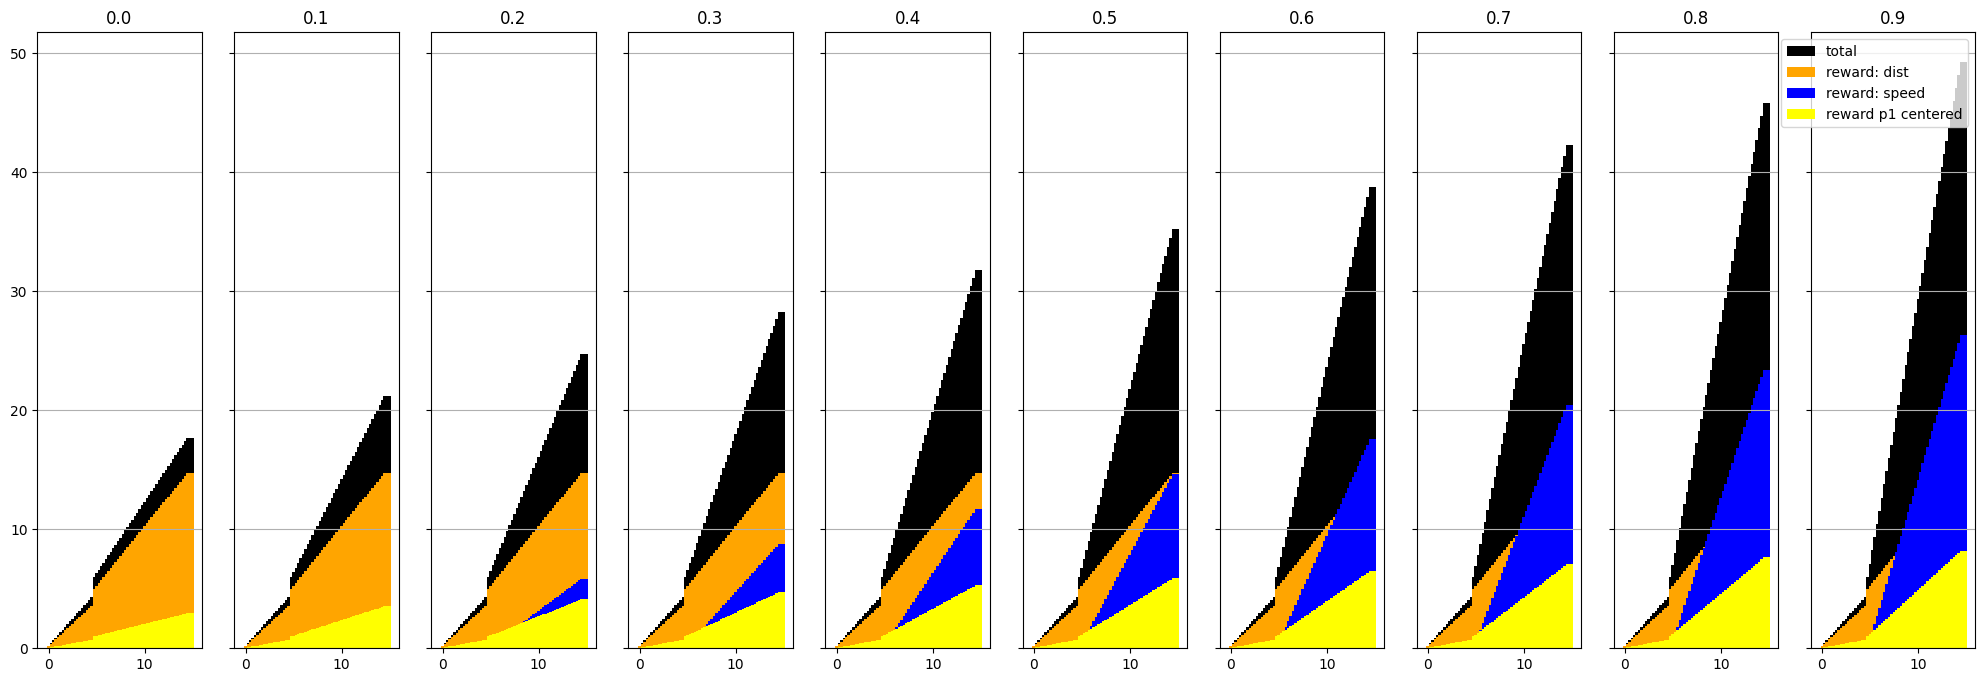

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def get_reward_(travelled_distance, dist_p1_C, 
                speed_z, speed_z_activation_dist=5, target_dist_p1_C=.15, 
                alpha=.75, beta=3, gamma=2):
    # speed_z in range [ 0., 1.]
    # dist_p1_C in range [-1., 1.]
    reward_A = travelled_distance * (alpha if travelled_distance < speed_z_activation_dist else 1.)
    reward_B = max(0, travelled_distance - speed_z_activation_dist) * beta * speed_z
    reward_C = (reward_A + reward_B) * np.interp(dist_p1_C, [ 0., 1.], [0.1, 1.]) * gamma
    return reward_A, reward_B, reward_C
    
fig, axes = plt.subplots(1,10, figsize=(25,8), sharey=True)
dists = np.arange(0.,15., .25)
for ax, speed in zip(axes, np.arange(0., 1.11, .1)):
    ax.set_title('%.1f' % speed)
    rewards = list(map(lambda d: get_reward_(d, 0, speed), dists))
    ax.bar(dists, list(map(sum, rewards)), color='black', label='total')
    ax.bar(dists, list(map(lambda r: r[0], rewards)), color='orange', label='reward: dist')
    ax.bar(dists, list(map(lambda r: r[1], rewards)), color='blue', label='reward: speed')
    ax.bar(dists, list(map(lambda r: r[2], rewards)), color='yellow', label='reward p1 centered')
    ax.grid(axis='y')
    plt.legend(loc='best')

## Drone & Line

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


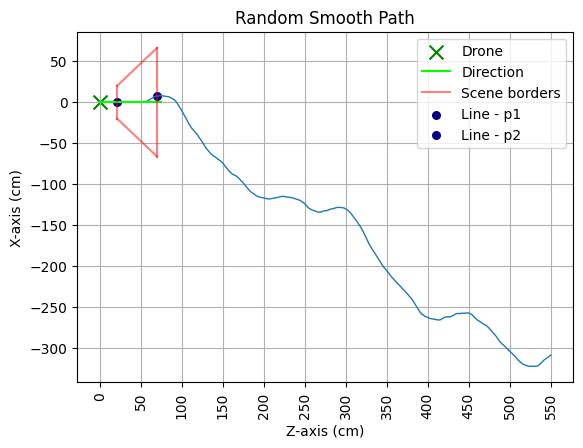

In [19]:
%load_ext autoreload
%autoreload 2
from Line import Line
from Drone import Drone
import matplotlib.pyplot as plt
seed = 23
fig = plt.figure()
line = Line(seed)
line.plot(show=False)
drone_params = {
    'seed': seed,
    'z_min_speed': z_min_speed,
    'z_max_speed': z_max_speed,
    'x_max_speed': x_max_speed,
    'max_angular_speed': max_angular_speed,
    'max_drift': max_drift,
    'allow_x_movement': allow_x_movement
}
drone = Drone(**drone_params)
drone.find_line(line)
drone.plot(show=False)
step = 50
ax = plt.gca()
ax.xaxis.set_major_locator(plt.MultipleLocator(step))
ax.yaxis.set_major_locator(plt.MultipleLocator(step))
ax.set_aspect('equal')
plt.legend()
plt.show()

## Environment

In [69]:
%load_ext autoreload
%autoreload 2
from Environment import Environment
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [70]:
testenv.drone.p1

[None, None]

In [71]:
environment_params = {
    'seed': seed,
    'max_allowed_dist': max_allowed_dist,
    'z_min_speed': z_min_speed,
    'z_max_speed': z_max_speed,
    'x_max_speed': x_max_speed,
    'max_angular_speed': max_angular_speed,
    'max_drift': max_drift,
    'allow_x_movement': allow_x_movement,
    'speed_z_activation_dist': speed_z_activation_dist,
    'target_dist_p1_C': target_dist_p1_C,
    'alpha': alpha,
    'beta':beta ,
    'gamma': gamma
}
testenv = Environment(**environment_params)
testout = widgets.Output(layout={'border': '1px solid black'})

In [77]:
action = {
    'speed_z': 0, # range [ 0,1] (0 = slow forward speed, 1 = fast forward speed)
    'speed_x': 0, # range [-1,1] (-1 = move left fast, 0 = no lateral movement, 1 = move right fast)
    'speed_a': -1, # range [-1,1] (-1 = turn left fast, 0 = no turn, 1 = turn right fast)
}

print('observation %s,\n reward %.3f, terminated %s, truncated %s' % testenv.step(list(action.values())))
testfig, testax = plt.subplots(figsize=(12, 8))
display(testout)
testenv.render(testout)

observation [-2, 1.0, 0.32272052081883285],
 reward 1.885, terminated True, truncated False


Output(layout=Layout(border_bottom='1px solid black', border_left='1px solid black', border_right='1px solid b…

<Figure size 640x480 with 0 Axes>

## Exploring ideas...

- what if we "mapped" the line? the drone would see the line and store the coordinates of both points. we would also try to calculate the coordinates of the drone in the scene. then we would calculate the nearest point on the mapped line from the drone and feed the model with this point and the N future ones along with the position of the drone. the hope would be that the model learns to correct the current drone trajectory to stick to the line but also try to predict the future events.

même en chargeant les weights d'une bonne version du modèle, on a un bon reward pendant quelques itérations puis ça drop.
ça montre que dans le code actuel on a qqch qui rend l'apprentissage difficile.
est-ce que c'est un bug? est-ce que c'est le reward?
en tout cas la vitesse angulaire est en moyenne toujours dans une extrême...